In [1]:
%load_ext autoreload
%autoreload 2
main_dir = r'../../..'
data_path = main_dir+'/data'
import sys
sys.path.append(main_dir)
from typing import List, Set, Dict, Optional, Any, Tuple, Type, Union

from BayDS.lib.pipeline import *
from BayDS.lib.io import *
import os


In [2]:
data_dir = f'{main_dir}/Snapshots/1/Test'
p = Pipeline(working_folder=f'{main_dir}/Snapshots/1/Dynamics')

p.add_node(LoaderNode, None, 'data',
           params={
               'input_directory': data_dir,
               'file': 'label_encoded_data.pkl'
           })
p.add_node(LoaderNode, None, 'oof',
           params={
               'input_directory': main_dir+'/Snapshots/Dynamic',
               'file': 'oof_all_data_best_lgb.csv'
           })
p.add_node(LoaderNode, None, 'predictions',
           params={
               'input_directory': main_dir+'/Snapshots/Dynamic',
               'file': 'prediction_all_data_best_lgb.csv'
           })
p.run(verbose=True)
p.save()

---------------------------
0: LoaderNode [2019-09-23 08:07:51]
params:
 {'input_directory': '../../../Snapshots/1/Test', 'file': 'label_encoded_data.pkl'}
---------------------------
1: LoaderNode [2019-09-23 08:07:56]
params:
 {'input_directory': '../../../Snapshots/Dynamic', 'file': 'oof_all_data_best_lgb.csv'}
---------------------------
2: LoaderNode [2019-09-23 08:07:57]
params:
 {'input_directory': '../../../Snapshots/Dynamic', 'file': 'prediction_all_data_best_lgb.csv'}


In [3]:
df = p.data['data']
df = df[['isFraud', 'new_card_id']]

In [6]:
pred = pd.concat([p.data['oof'].set_index('TransactionID')['isFraud'],p.data['predictions'].set_index('TransactionID')['isFraud']],axis=0)#
pred.index

Int64Index([2987000, 2987001, 2987002, 2987003, 2987004, 2987005, 2987006,
            2987007, 2987008, 2987009,
            ...
            4170230, 4170231, 4170232, 4170233, 4170234, 4170235, 4170236,
            4170237, 4170238, 4170239],
           dtype='int64', name='TransactionID', length=1097231)

In [7]:
pred

TransactionID
2987000    0.006236
2987001    0.006407
2987002    0.005103
2987003    0.001506
2987004    0.002891
             ...   
4170235    0.003395
4170236    0.003263
4170237    0.002492
4170238    0.003644
4170239    0.002183
Name: isFraud, Length: 1097231, dtype: float64

In [8]:
df['pred_0'] = pred

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
df

,isFraud,new_card_id,pred_0
TransactionID,,,
2987000,0,130935,0.006236
2987001,0,47322,0.006407
2987002,0,40076,0.005103
2987003,0,9790,0.001506
2987004,0,113643,0.002891
...,...,...,...
4170235,-1,21517,0.003395
4170236,-1,9161,0.003263
4170237,-1,48339,0.002492


In [13]:
test = df[['pred_0','new_card_id']].groupby('new_card_id').shift()

In [11]:
shifts = {}
for shift in range(-20,20):
    s = df[['pred_0','new_card_id']].groupby('new_card_id').shift(shift)['pred_0']
    shifts[shift] = s

In [12]:
for k,v in shifts.items():
    if k!=0:
        df[f'pred_{k}']=v

c:\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
df = df.fillna(-1)

In [14]:
X = df[df.isFraud>=0].drop(['isFraud'],axis=1)
y = df[df.isFraud>=0]['isFraud']
test = df[df.isFraud<0].drop(['isFraud'],axis=1)


In [15]:
X

,new_card_id,pred_0,pred_-20,pred_-19,pred_-18,pred_-17,pred_-16,pred_-15,pred_-14,pred_-13,...,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15,pred_16,pred_17,pred_18,pred_19
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,130935,0.006236,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2987001,47322,0.006407,0.007327,0.001376,0.001493,0.001002,0.130857,0.035905,0.019633,0.010979,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2987002,40076,0.005103,0.000293,0.000582,0.004512,0.001770,0.000996,0.001110,0.001337,0.000878,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2987003,9790,0.001506,0.001640,0.001096,0.001584,0.006199,0.008766,0.008774,0.002149,0.001472,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2987004,113643,0.002891,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.027184,0.000668,0.001350,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535,36490,0.000585,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3577536,115832,0.002893,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3577537,46747,0.000742,0.002706,0.578282,0.071343,0.006847,0.001905,0.002201,0.003809,0.005526,...,0.002019,0.001371,0.000888,0.003881,0.003739,0.001428,0.007937,0.006885,0.003876,0.001489


In [19]:
categorical_features = [c for c, col in enumerate(X.columns) if col in ['new_card_id']]


In [16]:
params = {'num_leaves': 200,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'max_bin': 50,
          'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.5899927210061127,
          'reg_lambda': 0.8485237330340494,
          'random_state': 47, 
#           'categorical_feature': categorical_features,
         }


In [17]:
from sklearn.model_selection import KFold
n_fold = 5
# folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)

In [18]:
from BayDS.lib.training import *

Using TensorFlow backend.
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as

Fold 1 started at Mon Sep 23 08:09:18 2019
Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.957332	training's auc: 0.957333	valid_1's auc: 0.91286	valid_1's auc: 0.91286
[200]	training's auc: 0.967589	training's auc: 0.967589	valid_1's auc: 0.916822	valid_1's auc: 0.916822
[300]	training's auc: 0.974684	training's auc: 0.974684	valid_1's auc: 0.918967	valid_1's auc: 0.918966
[400]	training's auc: 0.979569	training's auc: 0.979569	valid_1's auc: 0.919828	valid_1's auc: 0.919828
[500]	training's auc: 0.982876	training's auc: 0.982876	valid_1's auc: 0.920135	valid_1's auc: 0.920135
[600]	training's auc: 0.985563	training's auc: 0.985563	valid_1's auc: 0.920385	valid_1's auc: 0.920385
[700]	training's auc: 0.987615	training's auc: 0.987615	valid_1's auc: 0.920495	valid_1's auc: 0.920495
[800]	training's auc: 0.988902	training's auc: 0.988902	valid_1's auc: 0.920395	valid_1's auc: 0.920395
[900]	training's auc: 0.990081	training's auc: 0.990081	valid_1

[800]	training's auc: 0.988315	training's auc: 0.988316	valid_1's auc: 0.941991	valid_1's auc: 0.941991
[900]	training's auc: 0.989408	training's auc: 0.989408	valid_1's auc: 0.941628	valid_1's auc: 0.941629
[1000]	training's auc: 0.990406	training's auc: 0.990406	valid_1's auc: 0.941278	valid_1's auc: 0.941278
[1100]	training's auc: 0.991288	training's auc: 0.991288	valid_1's auc: 0.940856	valid_1's auc: 0.940856
[1200]	training's auc: 0.992061	training's auc: 0.992061	valid_1's auc: 0.940422	valid_1's auc: 0.940422
[1300]	training's auc: 0.992752	training's auc: 0.992752	valid_1's auc: 0.939865	valid_1's auc: 0.939865
[1400]	training's auc: 0.993292	training's auc: 0.993292	valid_1's auc: 0.939375	valid_1's auc: 0.939375
Early stopping, best iteration is:
[421]	training's auc: 0.978822	training's auc: 0.978822	valid_1's auc: 0.94278	valid_1's auc: 0.94278
CV mean score: 0.9404, std: 0.0113.


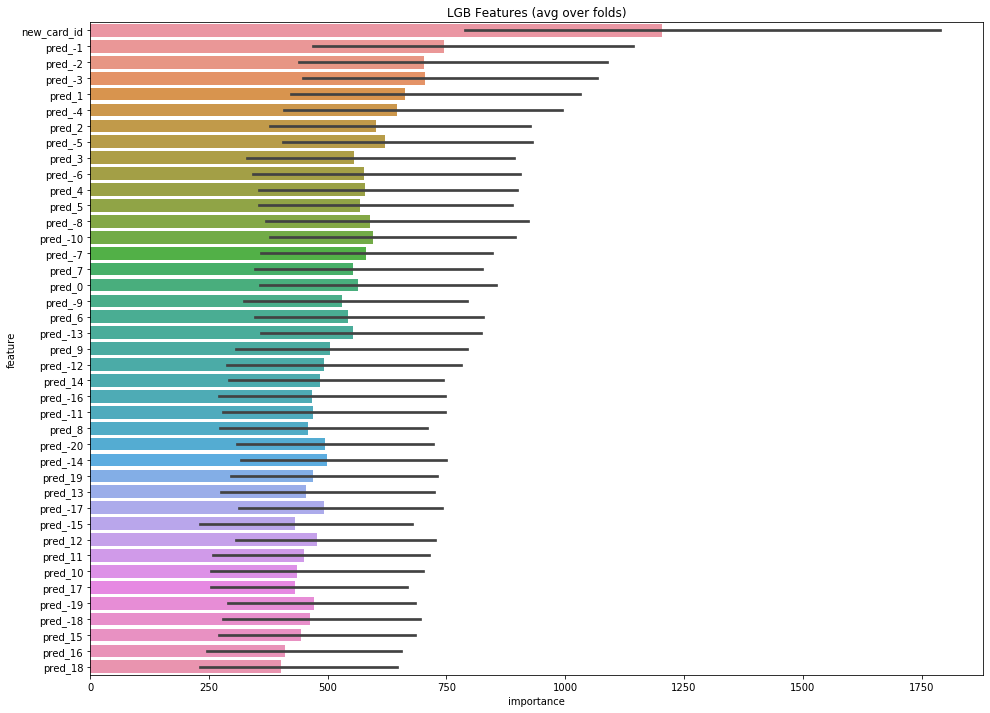

In [19]:
result_dict_lgb = train_model_classification(X=X, X_test=test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=100, early_stopping_rounds=1000, n_estimators=5000, averaging='usual', groups=None)

In [20]:
import pickle
pickle.dump(result_dict_lgb, open(f'{p.working_folder}/results_dict_lgbm_20_best.pkl','wb'))

In [21]:
# test = test.sort_values('Date')
test['prediction'] = result_dict_lgb['prediction']

In [22]:
# folder_path = './data/'
sub = pd.read_csv(f'{data_path}/sample_submission.csv')
sub['isFraud'] = pd.merge(sub, test['prediction'], on='TransactionID')['prediction']
sub.to_csv(f'{p.working_folder}/submission_dynamic_lgbm_20_best.csv', index=False)